In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from basic_functions import data_load

Loading all the neccesary data

In [11]:
X_train = data_load("data/X_train.csv")
y_train = data_load("data/y_train_clustered.csv")

X_test = data_load("data/X_test.csv")
y_test = data_load("data/y_test_clustered.csv")


Data loaded!
Data loaded!
Data loaded!
Data loaded!


In [12]:
from sklearn import tree
from sklearn.model_selection import train_test_split

clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [13]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit (Accuracy): {accuracy:.2f}")

# Classification Report: Precision, Recall, F1-Score
print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred, zero_division=0))


Genauigkeit (Accuracy): 0.81
Klassifikationsbericht:
              precision    recall  f1-score   support

        high       0.78      0.80      0.79       650
     highest       0.76      0.83      0.80       240
lower middle       0.82      0.85      0.84      1530
      lowest       0.84      0.80      0.82       852
      middle       0.82      0.79      0.80      1175

    accuracy                           0.81      4447
   macro avg       0.80      0.81      0.81      4447
weighted avg       0.82      0.81      0.81      4447



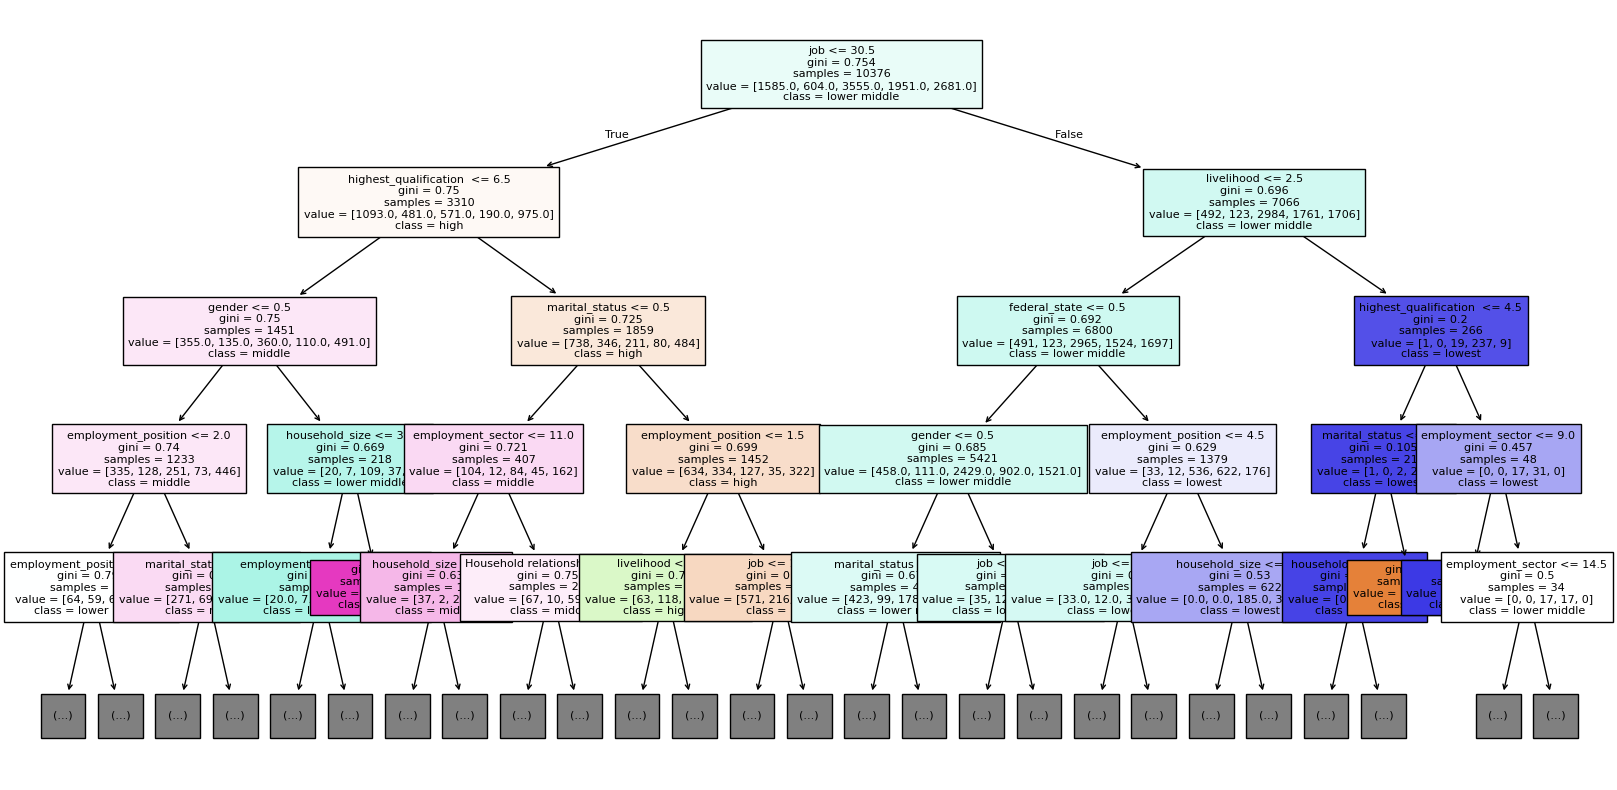

In [14]:
fig_size = plt.figure(figsize=(20,10))
tree.plot_tree(clf,
               feature_names=X_train.columns,
               class_names=clf.classes_,
               filled=True, 
               fontsize = 8, 
               max_depth=4)
plt.show()